# HX Cooling Performance — Combined Analysis (2025-10-21 & 2025-10-23)

Analysis of the no-mix baseline, mixed bath, and mixed bath with automatic LN control, using a common ambient heat leak derived from the warm-up log. Sensors: U1 bottom, U2 coil top, U3 bath top, U4 coil middle. The submerged heat-exchanger area in the antifreeze bath is 0.12 m².


## Paths, constants, helper imports


In [46]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hfe_ana import (
    apply_corrections,
    bath_capacity_j_per_k,
    fit_heat_leak_linear,
    fit_ua_from_corrected,
    heat_leak_subset,
    integrate_corrected_power,
    plot_heat_leak_fit,
    plot_power_and_flux,
    plot_temperatures,
    predict_heat_leak_fit,
    prepare_dataset,
    summarize_windows,
)

NB_PATH = Path.cwd()
REPO_ROOT = NB_PATH
for candidate in [NB_PATH, *NB_PATH.parents]:
    if (candidate / 'data').exists() and (candidate / 'analysis').exists():
        REPO_ROOT = candidate
        break

RAW_DIR = REPO_ROOT / 'data' / 'raw'
NOMIX_CSV = RAW_DIR / 'tc_log_20251021_152400-nomix.csv'
MIXED_CSV = RAW_DIR / 'tc_log_20251023_140530-mixed.csv'
AUTO_CSV = RAW_DIR / 'tc_log_20251023_142833-mixed_auto.csv'
WARMUP_CSV = RAW_DIR / 'tc_log_20251023_154857-warmup2.csv'

PROCESSED_DIR = REPO_ROOT / 'data' / 'processed'
REPORTS_DIR = REPO_ROOT / 'data' / 'reports'
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

ROLL_WINDOW_S = 45.0
WARMUP_TMIN_MIN = 20.0
EARLY_TMIN0 = 1.0
EARLY_TMIN1 = 5.0
EARLY_DT_MIN = 2.0
EARLY_DT_MAX = 12.0
SUMMARY_WINDOWS = [(2, 6), (6, 10), (10, 14)]
ENERGY_WINDOW = (2.0, 12.0)
HX_AREA_M2 = 0.12

GLYCOL_MASS_FRAC = 0.76
CP_GLYCOL_KJ_PER_KG_K = 2.42
CP_WATER_KJ_PER_KG_K = 4.18
RHO_GLYCOL_KG_PER_L = 1.113
RHO_WATER_KG_PER_L = 0.998
FILL_VOLUME_L = 5.4

cp_kJkgK = GLYCOL_MASS_FRAC * CP_GLYCOL_KJ_PER_KG_K + (1 - GLYCOL_MASS_FRAC) * CP_WATER_KJ_PER_KG_K
rho_kgL = GLYCOL_MASS_FRAC * RHO_GLYCOL_KG_PER_L + (1 - GLYCOL_MASS_FRAC) * RHO_WATER_KG_PER_L
Cp_JK = bath_capacity_j_per_k(FILL_VOLUME_L, rho_kgL, cp_kJkgK)
bath_mass_kg = FILL_VOLUME_L * rho_kgL
print(f'Bath Cp = {Cp_JK:,.0f} J/K; mixture cp = {cp_kJkgK:.3f} kJ/kg-K; bath mass = {bath_mass_kg:.2f} kg')

LN_DEWAR_GAUGE_PRESSURE_PSI = 25.0
LN_TUBING_ID_M = 3.87e-3  # 3.87 mm inner diameter
LN_TUBING_AREA_M2 = np.pi * (LN_TUBING_ID_M / 2.0) ** 2
LN_LIQUID_DENSITY_KG_M3 = 807.0  # liquid nitrogen at ~77 K
LN_PRESSURE_DROP_PA = LN_DEWAR_GAUGE_PRESSURE_PSI * 6894.75729
LN_EXIT_VELOCITY_MS = np.sqrt(2.0 * LN_PRESSURE_DROP_PA / LN_LIQUID_DENSITY_KG_M3)
LN_MASS_FLOW_KG_S = LN_LIQUID_DENSITY_KG_M3 * LN_TUBING_AREA_M2 * LN_EXIT_VELOCITY_MS
LN_VOL_FLOW_M3_S = LN_MASS_FLOW_KG_S / LN_LIQUID_DENSITY_KG_M3
print(f'Estimated LN mass flow = {LN_MASS_FLOW_KG_S:.3f} kg/s ({LN_VOL_FLOW_M3_S*1e6:.1f} mL/s)')


Bath Cp = 16,660 J/K; mixture cp = 2.842 kJ/kg-K; bath mass = 5.86 kg
Estimated LN mass flow = 0.196 kg/s (243.1 mL/s)


### Liquid-nitrogen mass-flow estimate

We approximate the transfer line as an inviscid nozzle that discharges liquid nitrogen from a dewar held at 25 psi gauge to the atmosphere. Taking the fluid density as $\rho=807\,\text{kg/m}^3$ at 77 K and neglecting losses (friction, flashing, valve throttling), Bernoulli’s equation gives the exit speed $v = \sqrt{2\Delta P/\rho}$. With a 3.87 mm inner-diameter tube, the cross-sectional area is $A=\pi d^2/4$, so the mass flow is $\dot{m}=\rho A v$. The calculation below records this idealised upper-bound in `LN_MASS_FLOW_KG_S` for subsequent use.


## Ambient heat leak determination

During the warm-up segment the bath is isolated from active control, so the only driver is the quasi-steady ambient heat leak $\dot{Q}_{\text{amb}}$. For a bath with effective heat capacity $C_p$, the lumped energy balance is

$$
C_p \frac{dT}{dt} = \dot{Q}_{\text{amb}}.
$$

Assuming $\dot{Q}_{\text{amb}}$ is approximately constant over this interval and the fluid remains well mixed (conditions that hold after 20 minutes), the solution is linear in time:

$$
T(t) = T_0 + \frac{\dot{Q}_{\text{amb}}}{C_p}\, t.
$$

We therefore fit a straight line to the bulk-mean temperature for times $t \ge 20$ min while the valve is closed. The regression slope $dT/dt$ (in °C/s) multiplied by the bath heat capacity $C_p$ gives the ambient heat leak in watts, and the intercept captures the starting temperature. Excluding the pre-20-minute data removes transient mixing curvature so the linear model remains valid.


,time_s,temp0_C,U1_bottom_C,U2_coilTop_C,U3_top_C,U4_coilMid_C,temp5_C,temp6_C,temp7_C,temp8_C,...,t_min,T_bulk_mean_C,T_coil_mean_C,DeltaT_C,Strat_top_minus_bottom_C,time_s_raw,valve_state,dataset,dTbulk_dt_C_per_s,P_bath_W
0,0.000,NaN,-9.51,-15.49,-8.33,-10.83,NaN,NaN,NaN,NaN,...,0.00000,-8.920,-13.160,4.24,1.18,7722.399,0,warmup,0.001254,-20.885530
1,1.005,NaN,-9.48,-15.52,-8.34,-10.84,NaN,NaN,NaN,NaN,...,0.01675,-8.910,-13.180,4.27,1.14,7723.404,0,warmup,0.001237,-20.613460
2,2.010,NaN,-9.55,-15.51,-8.28,-10.84,NaN,NaN,NaN,NaN,...,0.03350,-8.915,-13.175,4.26,1.27,7724.409,0,warmup,0.001581,-26.332403


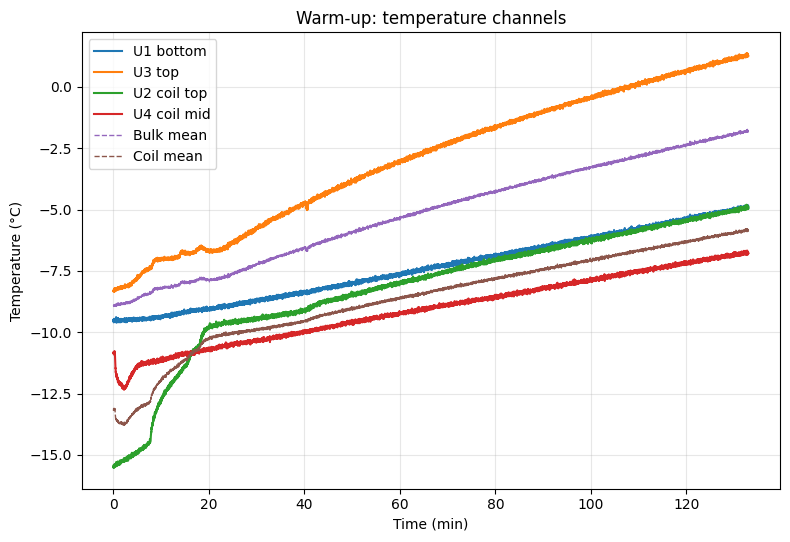

In [47]:
# 1) Inspect warm-up data and temperature channels
warmup_df, warmup_start = prepare_dataset(WARMUP_CSV, Cp_JK, label='warmup', window_s=ROLL_WINDOW_S)
display(warmup_df.head(3))
fig, ax = plot_temperatures(
    warmup_df,
    title='Warm-up: temperature channels',
    include_valve=False,
    height_scale=1.2,
)


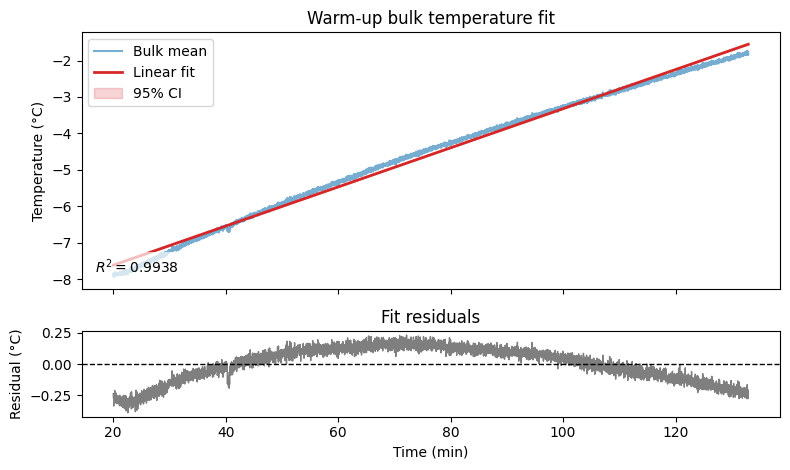

In [48]:
# 2) Fit the bulk mean temperature (t ≥ 20 min) and show residuals
warmup_subset = heat_leak_subset(warmup_df, tmin_start_min=WARMUP_TMIN_MIN, require_valve_closed=True)
fit_result = fit_heat_leak_linear(
    warmup_df,
    Cp_JK,
    tmin_start_min=WARMUP_TMIN_MIN,
    require_valve_closed=True,
)
predicted_C, lower_C, upper_C, se_C = predict_heat_leak_fit(fit_result, warmup_subset['time_s'])
fig_fit, ax_fit, ax_res = plot_heat_leak_fit(
    warmup_subset['t_min'],
    warmup_subset['T_bulk_mean_C'],
    predicted_C,
    band_lower_C=lower_C,
    band_upper_C=upper_C,
    residuals_C=warmup_subset['T_bulk_mean_C'] - predicted_C,
)


In [49]:
# 3) Heat leak summary
print(f'Warm-up samples used: {fit_result.n_samples}')
print(f'Ambient heat leak: {fit_result.heat_leak_W:.2f} W')
print(f'1σ uncertainty: {fit_result.heat_leak_sigma_W:.2f} W')
print(f'95% confidence interval: {fit_result.ci95_low_W:.2f} – {fit_result.ci95_high_W:.2f} W')
HEAT_LEAK_W = fit_result.heat_leak_W


Warm-up samples used: 6743
Ambient heat leak: 14.89 W
1σ uncertainty: 0.01 W
95% confidence interval: 14.87 – 14.92 W


## HX performance

For each dataset we assess the heat exchanger (HX) dynamics by plotting the corrected bath power and derived fluxes. The apparent bath power $P_{\text{bath}}$ comes from the rolling slope of the bulk mean temperature: using the bath heat capacity $C_p$, we compute

$$
P_{\text{bath}} = -C_p \, \frac{dT_{\text{bulk}}}{dt},
$$

where the negative sign reflects that a warming bath implies heat input. The corrected HX power removes the ambient leak so the curves represent only LN cooling:

$$
P_{\text{HX}} = P_{\text{bath}} + \dot{Q}_{\text{amb}},
$$

with $\dot{Q}_{\text{amb}}$ determined by the warm-up fit. The power panel in `plot_power_and_flux` shows both $P_{\text{HX}}$ and the corresponding conductance $UA$ obtained from the steady HX relation

$$
UA = \frac{P_{\text{HX}}}{\Delta T}, \qquad \Delta T = T_{\text{bulk mean}} - T_{\text{coil mean}}.
$$

To compare operating modes independent of hardware size we also compute the surface-normalised heat flux

$$
q'' = \frac{P_{\text{HX}}}{A_{\text{HX}}},
$$

and the per-area conductance $UA/A_{\text{HX}}$. These quantities populate the second subplot. Together the traces reveal how each run ramps power, whether a steady $\Delta T$ is maintained, and how the HX surface is utilised.



In [50]:
DATASETS = {
    'nomix': {'path': NOMIX_CSV, 'title': 'No-mix baseline', 'include_valve': False},
    'mixed': {'path': MIXED_CSV, 'title': 'Mixed bath', 'include_valve': False},
    'auto':  {'path': AUTO_CSV,  'title': 'Automatic valve', 'include_valve': True},
}

datasets: dict[str, pd.DataFrame] = {}
for key, meta in DATASETS.items():
    df, start_time = prepare_dataset(meta['path'], Cp_JK, label=key, window_s=ROLL_WINDOW_S)
    corrected = apply_corrections(df, HEAT_LEAK_W)
    corrected['P_HX_W_m2'] = corrected['P_HX_W'] / HX_AREA_M2
    corrected['UA_per_area_W_per_m2K'] = corrected['UA_corr_W_per_K'] / HX_AREA_M2
    datasets[key] = corrected
    duration = corrected['t_min'].iloc[-1]
    print(f"Loaded {key}: start={start_time:.1f}s, duration={duration:.2f} min")
print(f'Ambient heat leak applied: {HEAT_LEAK_W:.2f} W')


Loaded nomix: start=12.1s, duration=15.11 min
Loaded mixed: start=1525.6s, duration=21.96 min
Loaded auto: start=2906.5s, duration=12.38 min
Ambient heat leak applied: 14.89 W


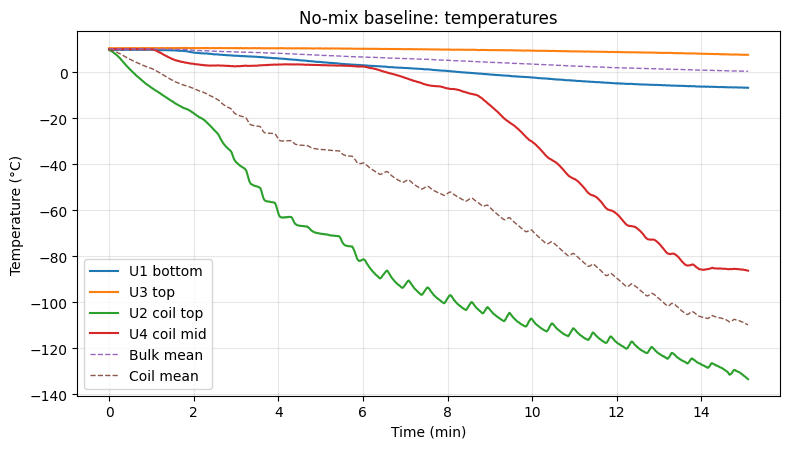

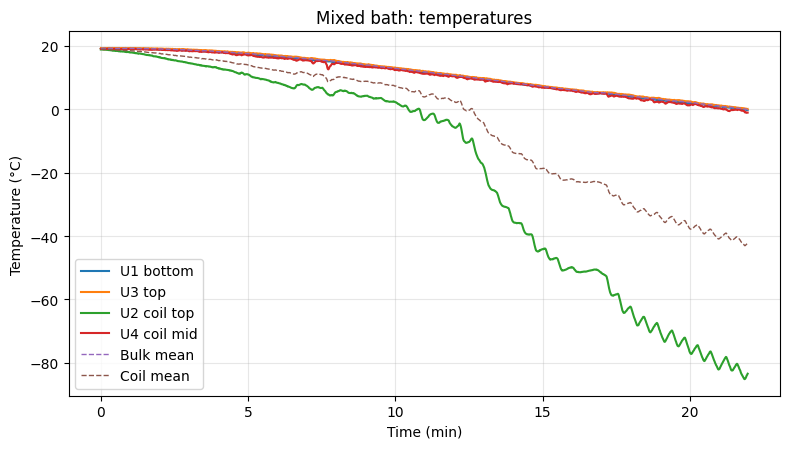

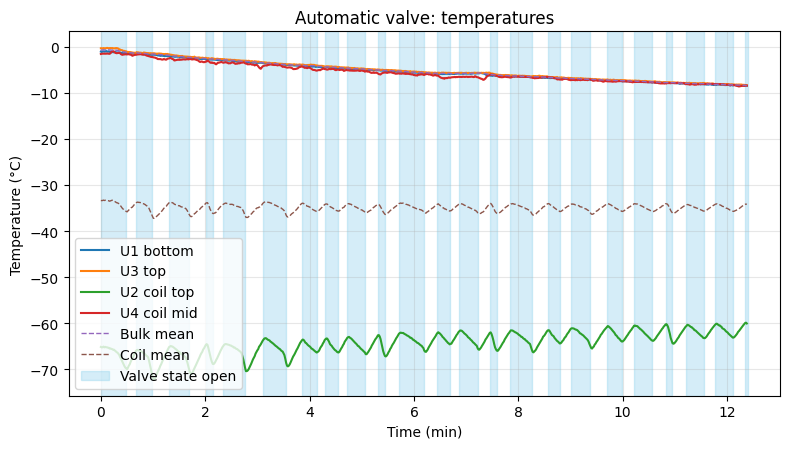

In [51]:
for key, meta in DATASETS.items():
    fig, _ = plot_temperatures(
        datasets[key],
        title=f"{meta['title']}: temperatures",
        include_valve=meta.get('include_valve', False),
    )
    fig


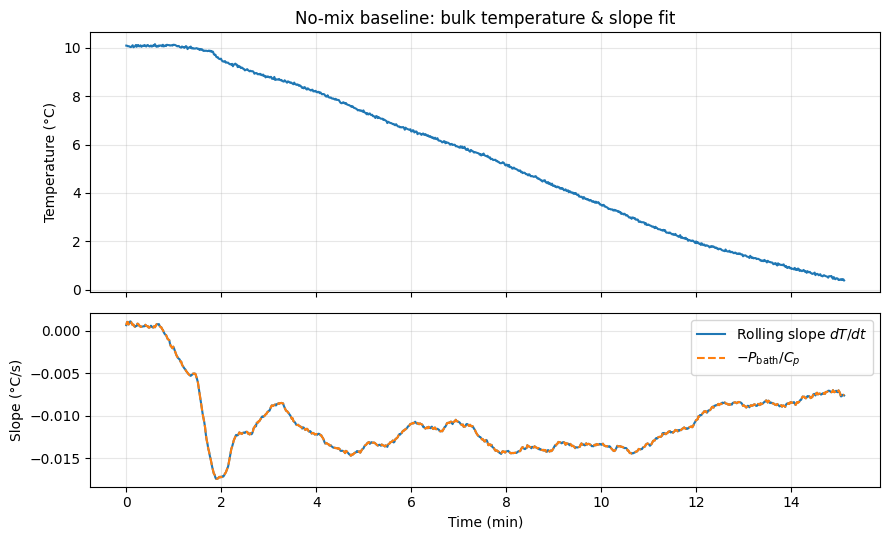

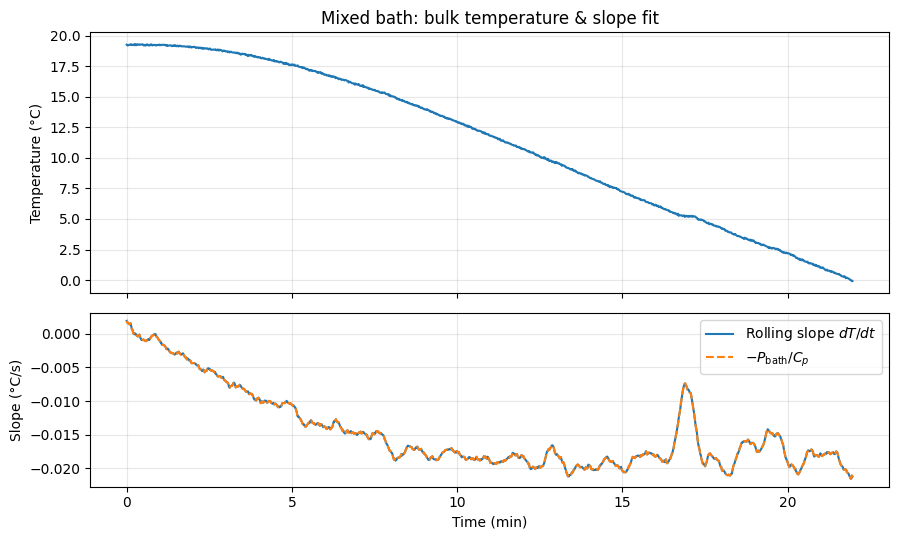

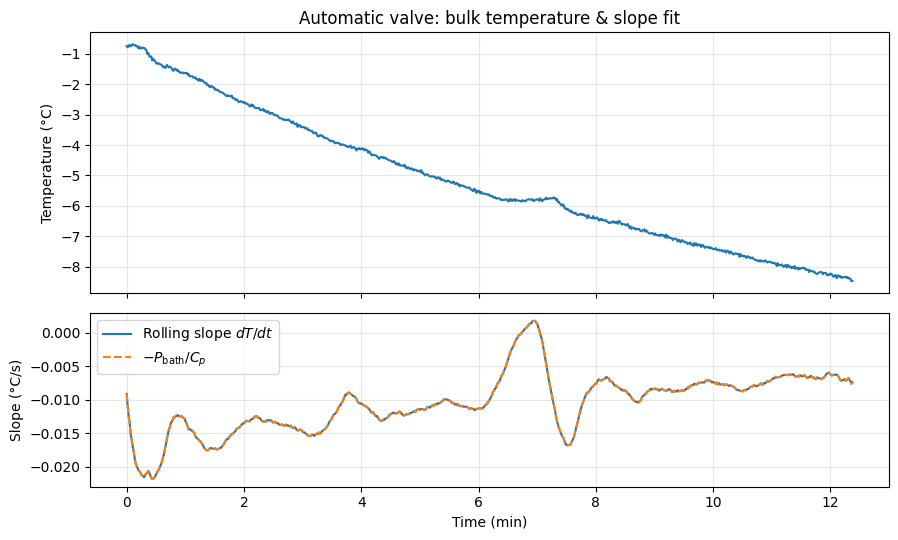

In [52]:
for key, meta in DATASETS.items():
    df = datasets[key]
    if df.empty or 'T_bulk_mean_C' not in df.columns:
        continue
    t_min = df['t_min']
    fig, axes = plt.subplots(2, 1, figsize=(9, 5.5), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

    axes[0].plot(t_min, df['T_bulk_mean_C'], label='Bulk mean')
    axes[0].set_ylabel('Temperature (°C)')
    axes[0].set_title(f"{meta['title']}: bulk temperature & slope fit")
    axes[0].grid(True, alpha=0.3)

    if 'dTbulk_dt_C_per_s' in df.columns and 'P_bath_W' in df.columns:
        slope_vals = df['dTbulk_dt_C_per_s']
        derived_slope = -df['P_bath_W'] / Cp_JK
        axes[1].plot(t_min, slope_vals, label=r"Rolling slope $dT/dt$")
        axes[1].plot(t_min, derived_slope, linestyle='--', label=r"$-P_{\mathrm{bath}}/C_p$")
        axes[1].set_ylabel('Slope (°C/s)')
        axes[1].legend(loc='best')
    else:
        axes[1].text(0.5, 0.5, 'Slope columns unavailable', ha='center', va='center')
        axes[1].set_ylabel('Slope (°C/s)')
    axes[1].set_xlabel('Time (min)')
    axes[1].grid(True, alpha=0.3)

    fig.tight_layout()
    plt.show()



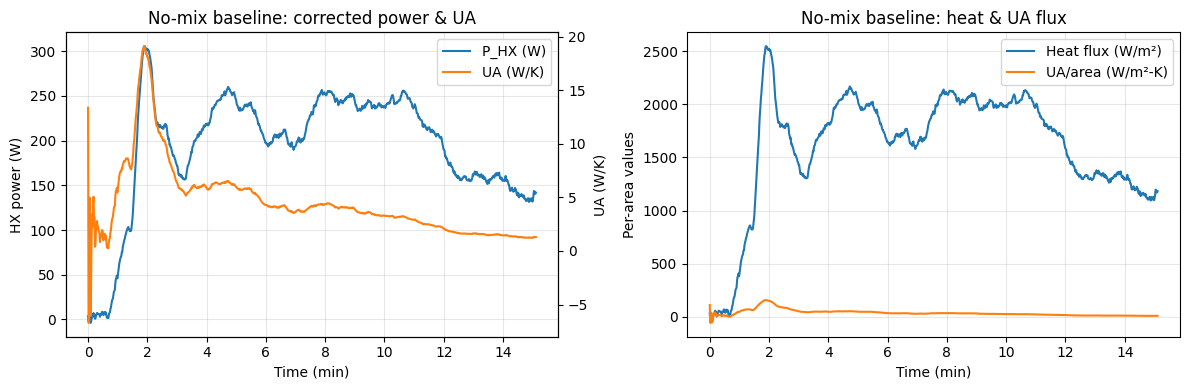

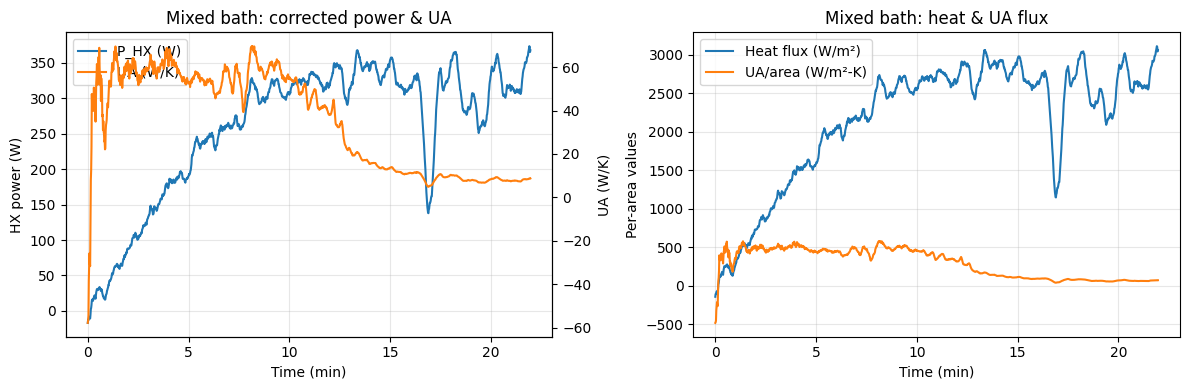

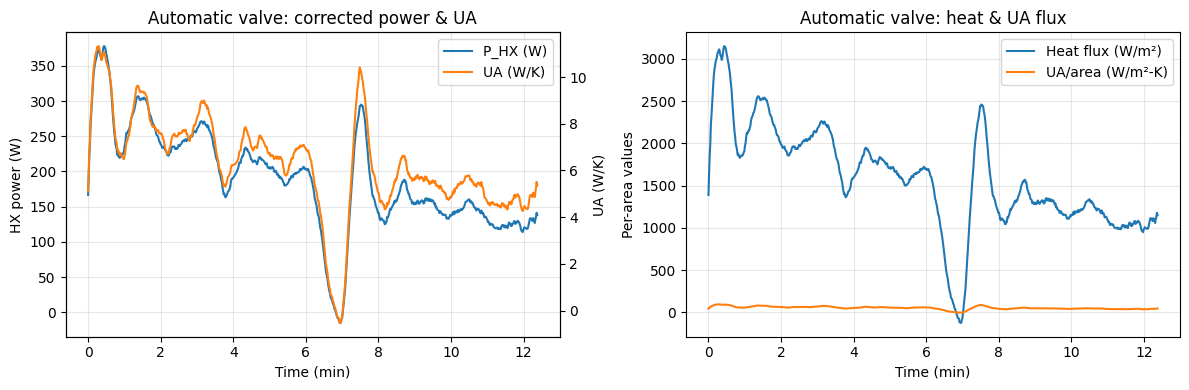

In [53]:
from IPython.display import display

for key, meta in DATASETS.items():
    fig, *_ = plot_power_and_flux(datasets[key], title_prefix=meta['title'])


## Key metrics & exports

The tables and figures below simply aggregate the previously defined quantities over fixed windows and export them for reports. Median, percentile, and energy summaries are all derived from $P_{\text{HX}}$, $q''$, $UA$, and $\Delta T$ as introduced above, with the total HX energy obtained by integrating $P_{\text{HX}}$ over the specified interval.



In [54]:
summary_frames = []
for key, df in datasets.items():
    summary = summarize_windows(df, SUMMARY_WINDOWS)
    summary.insert(0, 'dataset', key)
    summary_frames.append(summary)
summary_df = pd.concat(summary_frames, ignore_index=True)
summary_df


,dataset,window_min,samples,P_HX_median_W,P_HX_p10_W,P_HX_p90_W,Heat_flux_median_W_m2,UA_median_W_per_K,UA_flux_median_W_per_m2K,DeltaT_median_C
0,nomix,2-6,239,219.316895,173.784802,253.857784,1827.640795,6.064719,50.539326,37.2700
1,nomix,6-10,239,237.693693,197.100359,251.939350,1980.780778,4.023659,33.530492,58.1350
2,nomix,10-14,238,189.965245,156.447914,246.765170,1583.043706,2.077494,17.312449,91.4400
3,mixed,2-6,239,179.409639,104.793964,238.344605,1495.080321,57.668620,480.571831,2.7650
4,mixed,6-10,238,293.922649,248.288127,322.134466,2449.355409,56.849437,473.745312,5.0800
5,mixed,10-14,239,326.419087,311.813384,348.049990,2720.159060,40.302490,335.854082,8.1250
6,auto,2-6,239,215.794686,185.203303,256.780593,1798.289051,7.015769,58.464744,30.7800
7,auto,6-10,239,154.571060,26.462212,217.629132,1288.092170,5.464820,45.540167,28.6000
8,auto,10-14,142,130.204819,119.200288,151.946582,1085.040157,4.902696,40.855798,26.9875


In [55]:
energy_rows = []
for key, df in datasets.items():
    t1 = min(ENERGY_WINDOW[1], float(df['t_min'].max()))
    energy_kJ = integrate_corrected_power(df, ENERGY_WINDOW[0], t1)
    energy_rows.append({'dataset': key, 'window_min': f"{ENERGY_WINDOW[0]}-{t1:.1f}", 'E_HX_kJ': energy_kJ})
energy_df = pd.DataFrame(energy_rows)
energy_df


,dataset,window_min,E_HX_kJ
0,nomix,2.0-12.0,135.125664
1,mixed,2.0-12.0,147.706183
2,auto,2.0-12.0,103.125955


In [56]:
print(f"Ambient heat leak: {fit_result.heat_leak_W:.2f} W (95% CI {fit_result.ci95_low_W:.2f}-{fit_result.ci95_high_W:.2f} W)")
for key in DATASETS:
    flux = summary_df[(summary_df['dataset'] == key) & (summary_df['window_min'] == '6-10')]['Heat_flux_median_W_m2']
    flux_val = flux.iloc[0] if not flux.empty else float('nan')
    energy_val = energy_df.loc[energy_df['dataset'] == key, 'E_HX_kJ'].iloc[0]
    window_label = energy_df.loc[energy_df['dataset'] == key, 'window_min'].iloc[0]
    print(f"{key} median heat flux 6-10 min: {flux_val:.0f} W/m²")
    print(f"{key} integrated HX energy {window_label} min: {energy_val:.1f} kJ")


Ambient heat leak: 14.89 W (95% CI 14.87-14.92 W)
nomix median heat flux 6-10 min: 1981 W/m²
nomix integrated HX energy 2.0-12.0 min: 135.1 kJ
mixed median heat flux 6-10 min: 2449 W/m²
mixed integrated HX energy 2.0-12.0 min: 147.7 kJ
auto median heat flux 6-10 min: 1288 W/m²
auto integrated HX energy 2.0-12.0 min: 103.1 kJ


In [57]:
summary_out = REPORTS_DIR / 'hx_summary_windows_combined.csv'
energy_out = REPORTS_DIR / 'hx_energy_combined.csv'
leak_out = REPORTS_DIR / 'hx_heat_leak_20251023.txt'
summary_df.to_csv(summary_out, index=False)
energy_df.to_csv(energy_out, index=False)
with leak_out.open('w') as fh:
    fh.write(f"Ambient heat leak (t ≥ {WARMUP_TMIN_MIN} min): {fit_result.heat_leak_W:.4f} W\n")
    fh.write(f"1σ uncertainty: {fit_result.heat_leak_sigma_W:.4f} W\n")
    fh.write(f"95% CI: {fit_result.ci95_low_W:.4f} – {fit_result.ci95_high_W:.4f} W\n")
print('Saved:', summary_out)
print('Saved:', energy_out)
print('Saved:', leak_out)
for key, df in datasets.items():
    timeseries_out = PROCESSED_DIR / f'hx_timeseries_20251023_{key}.csv'
    keep = [
        'dataset',
        'time_s',
        'time_s_raw',
        't_min',
        'T_bulk_mean_C',
        'T_coil_mean_C',
        'DeltaT_C',
        'P_bath_W',
        'P_HX_W',
        'P_HX_W_m2',
        'UA_corr_W_per_K',
        'UA_per_area_W_per_m2K',
        'valve_state',
    ]
    cols = [c for c in keep if c in df.columns]
    df.loc[:, cols].to_csv(timeseries_out, index=False)
    print('Saved:', timeseries_out)

Saved: /home/pocar-lab/Documents/HFE_System/data/reports/hx_summary_windows_combined.csv
Saved: /home/pocar-lab/Documents/HFE_System/data/reports/hx_energy_combined.csv
Saved: /home/pocar-lab/Documents/HFE_System/data/reports/hx_heat_leak_20251023.txt
Saved: /home/pocar-lab/Documents/HFE_System/data/processed/hx_timeseries_20251023_nomix.csv
Saved: /home/pocar-lab/Documents/HFE_System/data/processed/hx_timeseries_20251023_mixed.csv
Saved: /home/pocar-lab/Documents/HFE_System/data/processed/hx_timeseries_20251023_auto.csv


## Takeaways

- Warm-up drift after 20 min is extremely linear, giving an ambient heat leak ≈ 15 W with a narrow confidence interval.
- Manual LN flow sustains higher heat flux and UA than the automatic valve control over comparable windows.
- Exported CSV/TXT artifacts provide shared inputs for follow-up analyses or comparisons with future runs.
